# sarimax 

In [ ]:
--the necessary comment will be given 

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7.5]

In [2]:
macro_data = sm.datasets.macrodata.load_pandas().data

In [3]:
macro_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


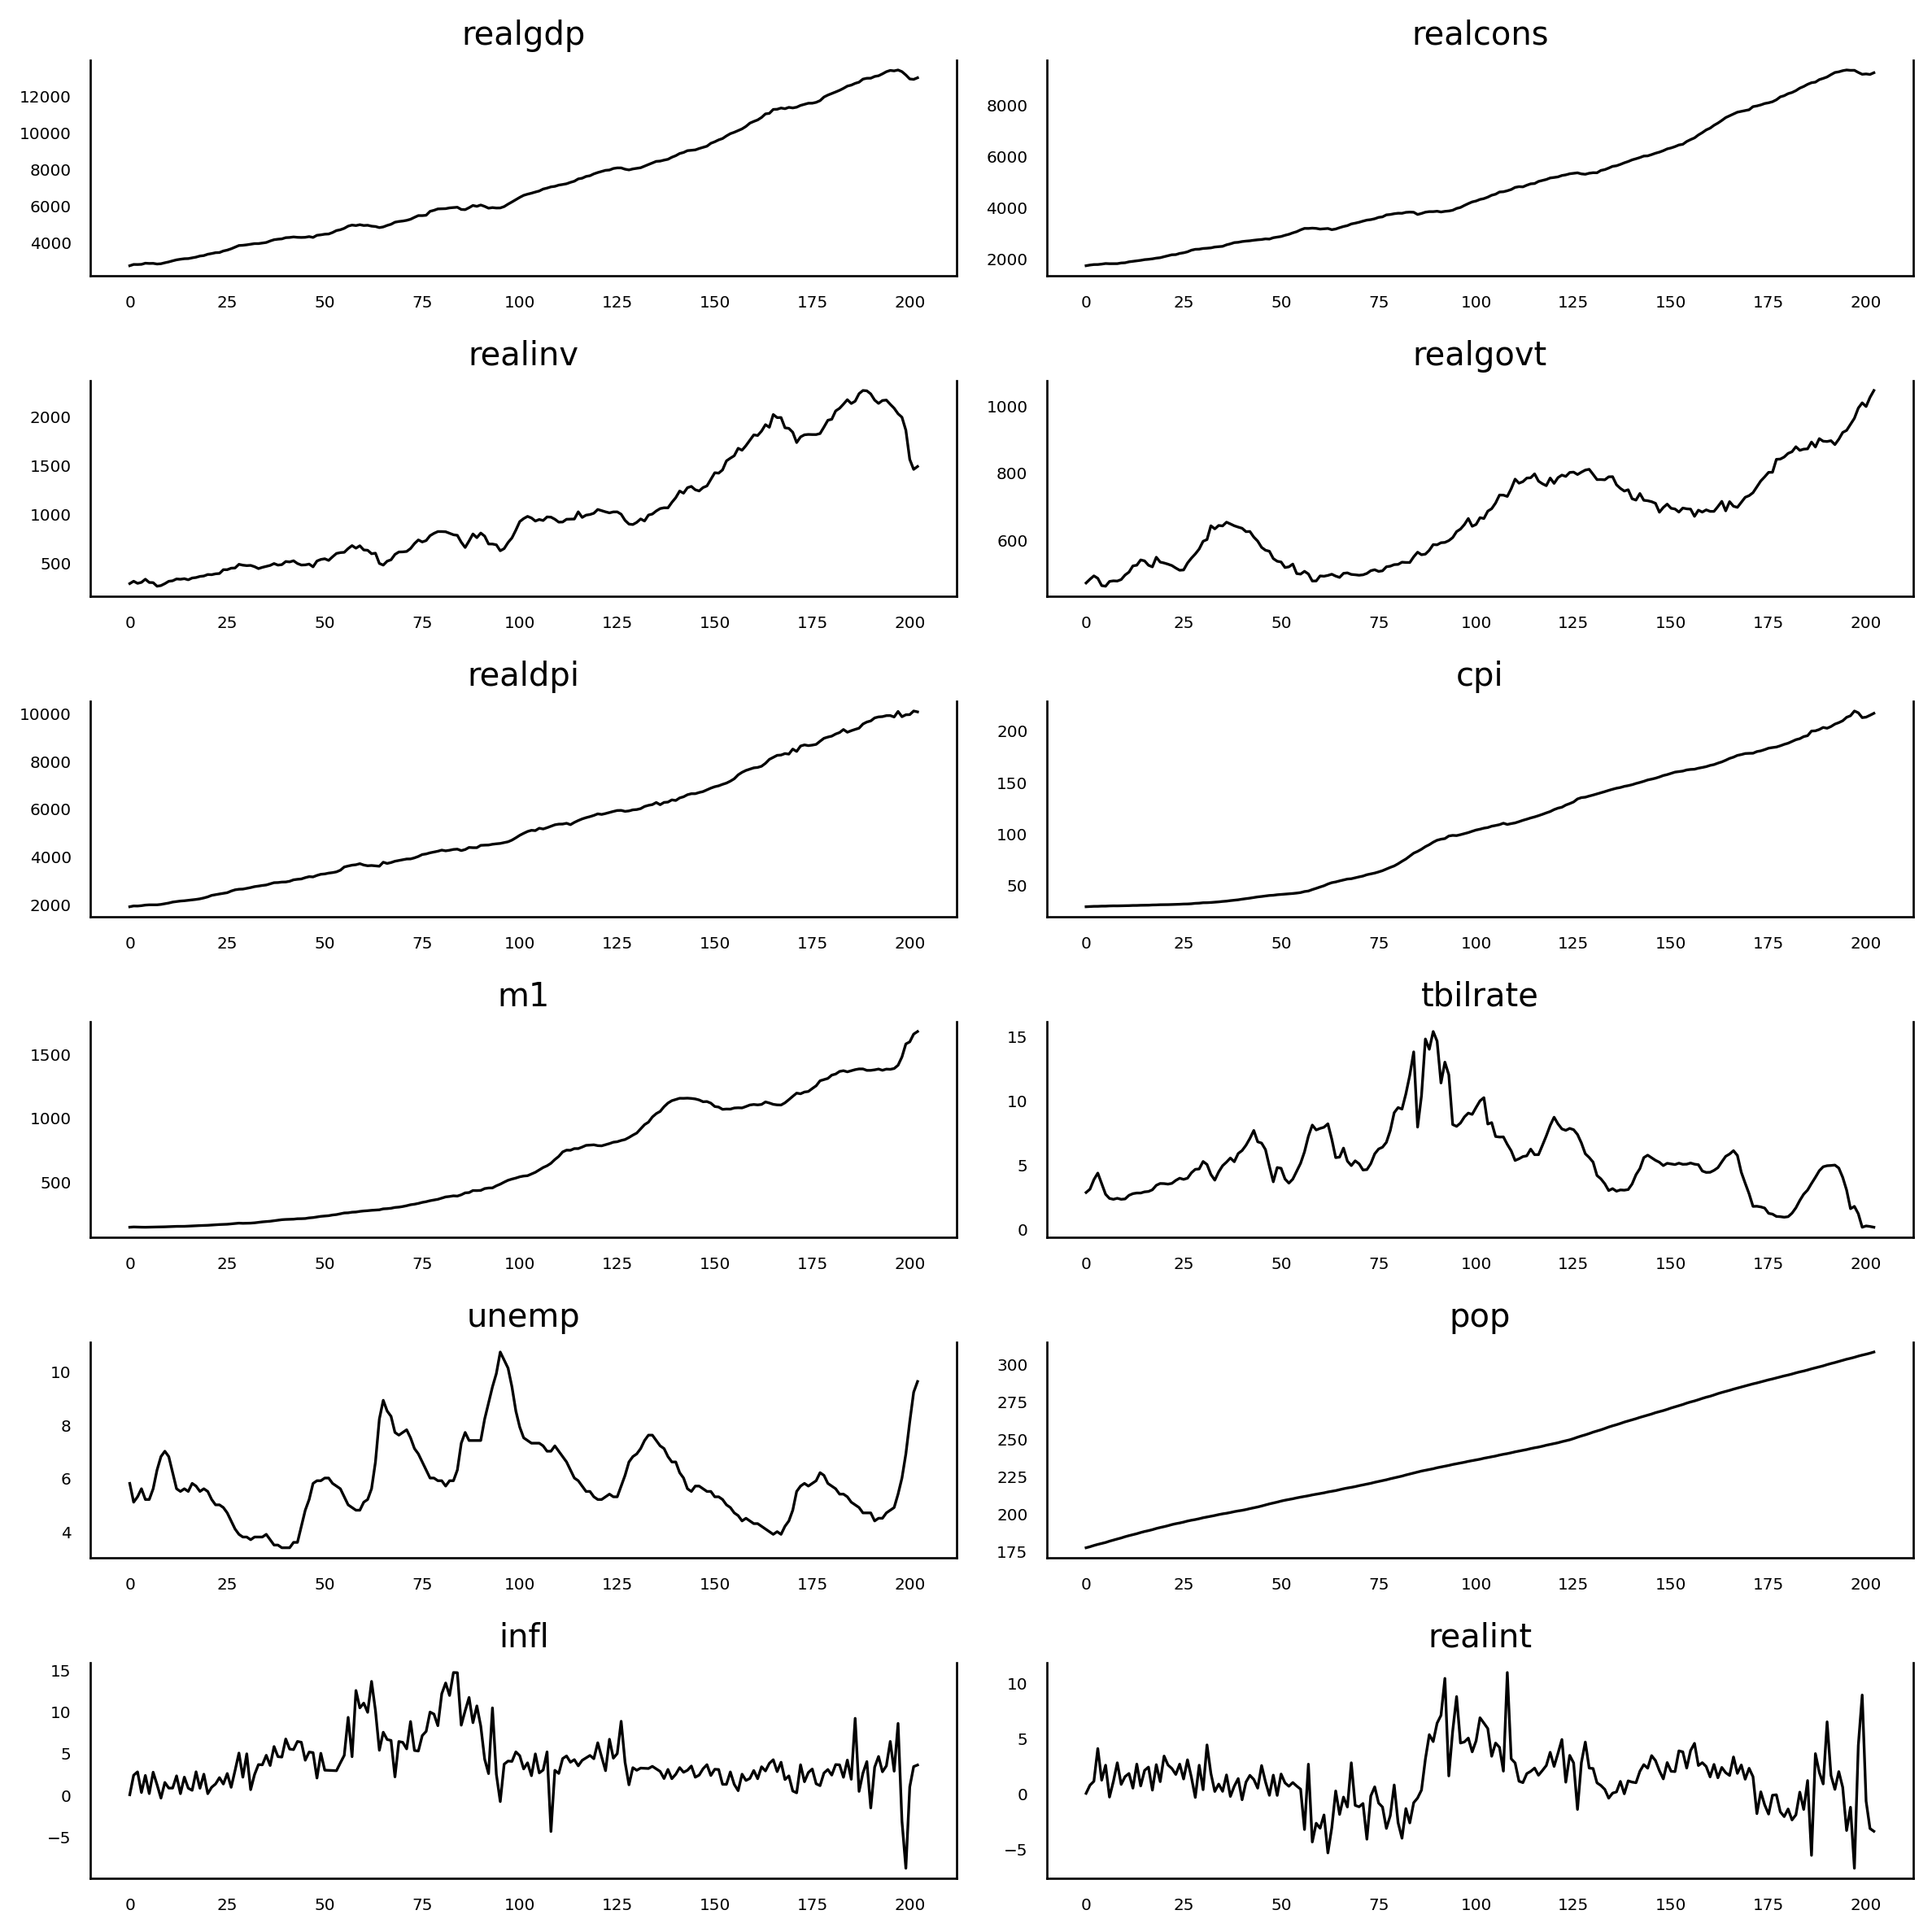

In [4]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, dpi = 240, figsize = (10,10))

for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i+2]]
    
    ax.plot(data, color = 'black', linewidth = 1)
    ax.set_title(macro_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize = 6)
    
plt.tight_layout()    

In [5]:
macro_data['realgdp_tr1'] = macro_data['realgdp'].diff()

macro_data.head(3)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,realgdp_tr1
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,NaN
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,68.452
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,-3.313


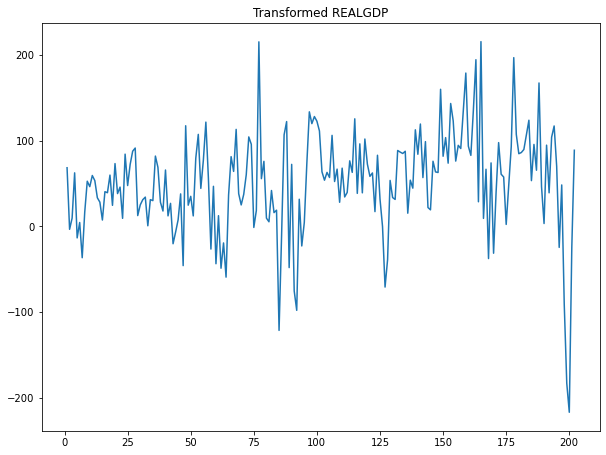

In [6]:
plt.plot(macro_data['realgdp_tr1'])
plt.title("Transformed REALGDP")
plt.show()

In [7]:
ad_fuller_result = adfuller(macro_data['realgdp_tr1'][1:])

print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658104
p-value: 3.327882187668259e-08


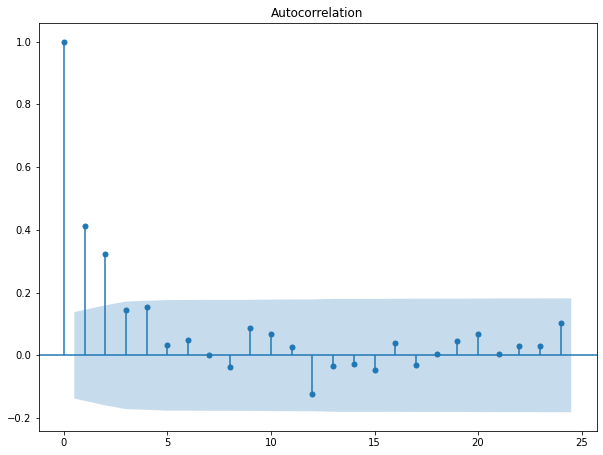

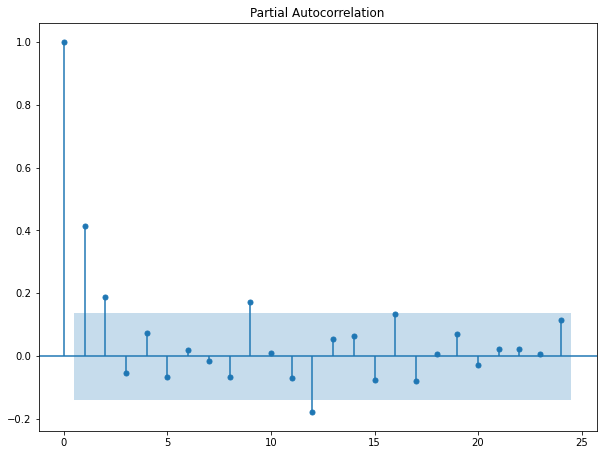

In [8]:
plot_acf(macro_data['realgdp_tr1'][1:]);
plot_pacf(macro_data['realgdp_tr1'][1:]);

In [9]:
def optimize_SARIMAX(endog, exog, parameters_list, d, D, s):
    """
        Returns dataframe with parameters, corresponding AIC
        
        endog - the observed variable
        exog - the exogenous variables
        parameters_list - list with (p, d, P, Q)tuples
        d - integration order
        D - seasonal integration order
        s - length of the season
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(endog,
                           exog,
                           order=(param[0], d, param[1]),
                           seasonal_order=(param[2], D, param[3], s),
                           simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [11]:
endog = macro_data['realgdp'][:200]
exog = macro_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']][:200]

result_df = optimize_SARIMAX(endog, exog, parameters_list, 1, 0, 4)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(2, 2, 1, 0)",1757.209827
1,"(3, 3, 0, 0)",1757.890234
2,"(2, 2, 0, 2)",1758.302329
3,"(2, 2, 0, 0)",1759.101794
4,"(2, 2, 2, 0)",1759.856224
...,...,...
251,"(3, 2, 2, 1)",1776.806690
252,"(3, 2, 1, 3)",1776.867130
253,"(3, 2, 1, 1)",1776.944895
254,"(3, 2, 1, 2)",1778.132384


In [12]:
best_model = SARIMAX(endog, 
                     exog, 
                     order=(2,1,2), 
                     seasonal_order=(1,0,0,4), #4nya seasonal
                    simple_differencing=False)
res = best_model.fit(dis=False)

print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            realgdp   No. Observations:                  200
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -861.605
Date:                            Sat, 30 Apr 2022   AIC                           1757.210
Time:                                    22:32:34   BIC                           1813.196
Sample:                                         0   HQIC                          1779.869
                                            - 200                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9564      0.053     17.917      0.000       0.852       1.061
realinv        1.0004      0.042   

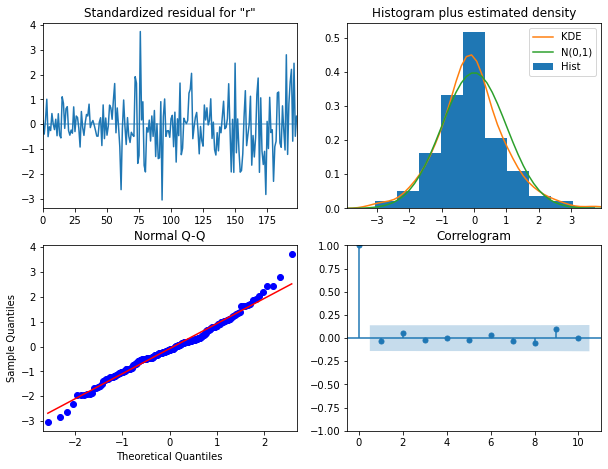

In [13]:
res.plot_diagnostics();

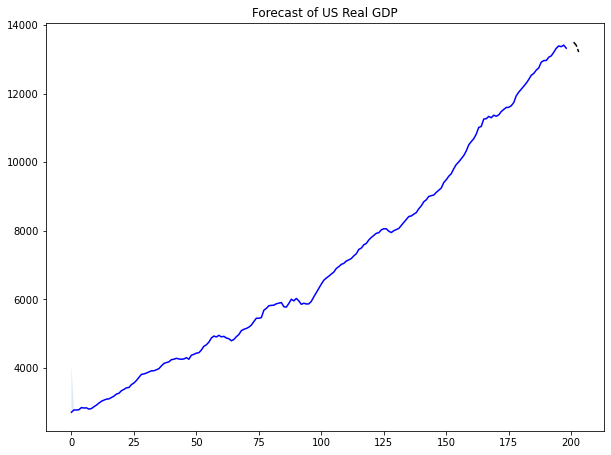

In [14]:
n_forecast = 3
predict = res.get_prediction(end=best_model.nobs + n_forecast,
                            exog = exog.iloc[-4:])
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

fig, ax = plt.subplots()
ax.plot(macro_data['realgdp'][:199], color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)

ax.set_title('Forecast of US Real GDP')
plt.show()

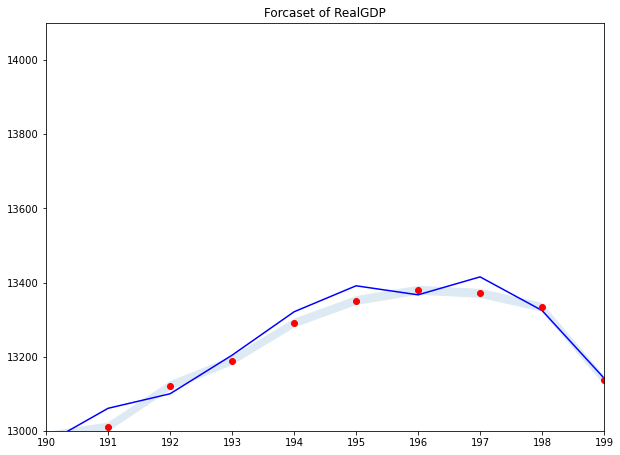

In [15]:
fig, ax = plt.subplots()
ax.plot(macro_data['realgdp'], color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.plot(predict.predicted_mean, 'ro')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)
ax.set_xlim(190,199)
ax.set_ylim(13000, 14100)

ax.set_title('Forcaset of RealGDP')
plt.show()

In [16]:
mse = mean_squared_error(macro_data['realgdp'], predict.predicted_mean[:203])

print(f'MSE: {mse}')

MSE: 7059.873379914856


In [17]:
mape = np.mean(np.abs(macro_data['realgdp'] - predict.predicted_mean[:203]) / np.abs(macro_data['realgdp']))

print(f'MAPE: {round(mape * 100, 2)}%')

MAPE: 0.39%


# arima 

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [9, 7.5]

In [20]:
data = pd.read_csv('data/jj.csv')
data.head(3)

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85


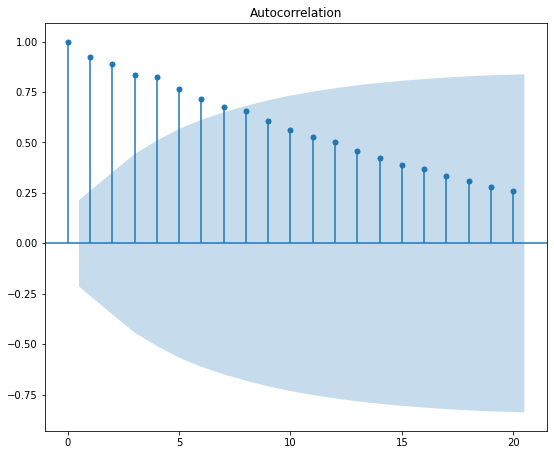

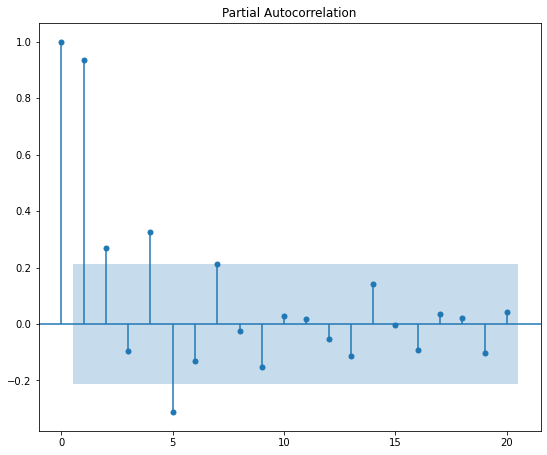

In [21]:
plot_acf(data['data']);
plot_pacf(data['data']);

grafik di atas bersifat monoton turun dan sinusoidal, artinya belum memberikan informasi penting selain mengatakan datanya tidak bersifat stasioner

In [22]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head(3)

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517


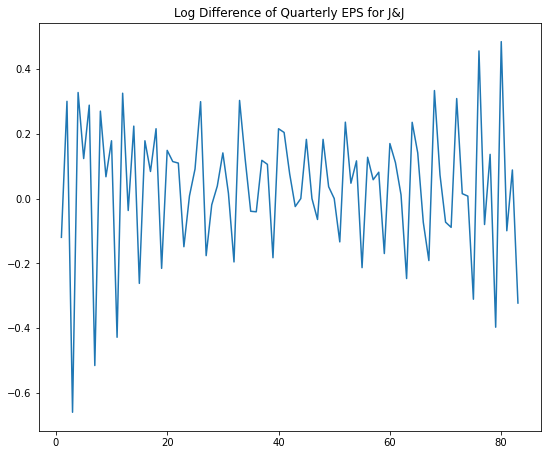

In [23]:
plt.plot(data['data_tr_1'])
plt.title("Log Difference of Quarterly EPS for J&J")
plt.show()

In [24]:
ad_fuller_result = adfuller(data['data_tr_1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811828
p-value: 0.0004149731404440809


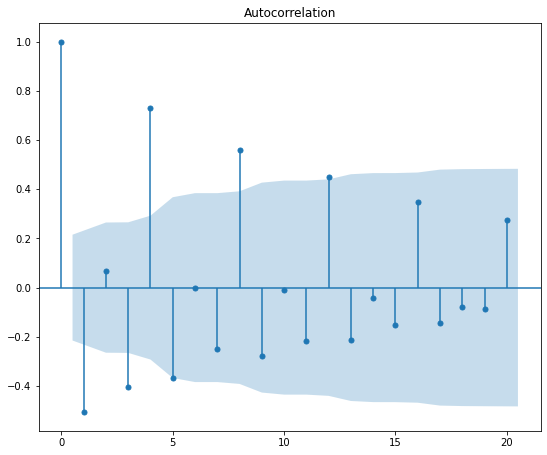

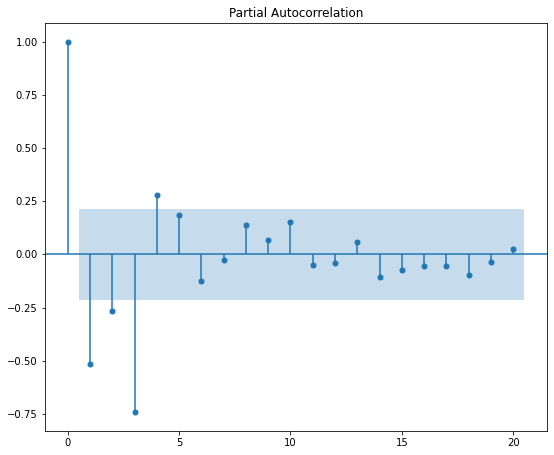

In [25]:
plot_acf(data['data_tr_1'][1:]);
plot_pacf(data['data_tr_1'][1:]);

In [26]:
def optimize_ARIMA(endog, order_list):
    """
    returns a dataframe with parameters and corresponding AIC
    
    order_list - list with (p,d,q) tuples
    endog - the observed variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order = order, simple_differencing = False).fit(disp = False)
        except:
            continue
        
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)', 'AIC']
    result_df = result_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)
    
    return result_df

In [27]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
order_list[:10]    

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [28]:
result_df = optimize_ARIMA(data['data'], order_list)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p,d,q)",AIC
0,"(6, 1, 3)",115.317739
1,"(4, 1, 6)",115.859343
2,"(7, 1, 1)",116.076266
3,"(5, 1, 3)",116.534580
4,"(5, 1, 4)",117.244084
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


In [29]:
best_model = SARIMAX(data['data'], order = (6, 1, 3), simple_differencing = False)
res = best_model.fit(disp = False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -47.659
Date:                Sat, 30 Apr 2022   AIC                            115.318
Time:                        22:39:20   BIC                            139.506
Sample:                             0   HQIC                           125.035
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4710      0.123    -11.997      0.000      -1.711      -1.231
ar.L2         -0.7646      0.145     -5.275      0.000      -1.049      -0.481
ar.L3          0.0423      0.062      0.684      0.4

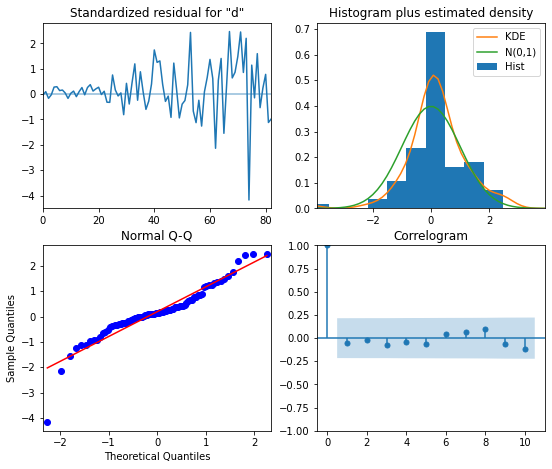

In [30]:
res.plot_diagnostics();

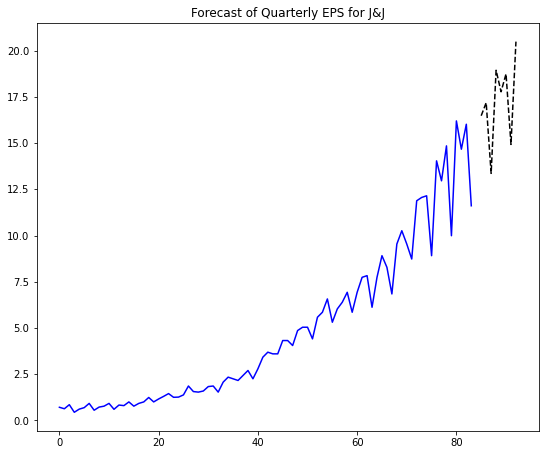

In [31]:
n_forecast = 8

predict = res.get_prediction(end = best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title = 'Forecast of Quarterly EPS for J&J')
plt.show()

In [32]:
data['model'] = predict.predicted_mean
data.head(9)

,date,data,data_tr_1,model
0,1960-01-01,0.71,NaN,0.000000
1,1960-04-01,0.63,-0.119545,0.709998
2,1960-07-02,0.85,0.299517,0.680263
3,1960-10-01,0.44,-0.658462,0.721874
4,1961-01-01,0.61,0.326684,0.649330
5,1961-04-02,0.69,0.123233,0.527411
6,1961-07-02,0.92,0.287682,0.788212
7,1961-10-01,0.55,-0.514455,0.487155
8,1962-01-01,0.72,0.269333,0.650333


In [33]:
data.tail(8)

,date,data,data_tr_1,model
76,1979-01-01,14.04,0.454736,13.590752
77,1979-04-02,12.96,-0.080043,13.017533
78,1979-07-02,14.85,0.136132,14.223133
79,1979-10-01,9.99,-0.396415,10.199399
80,1980-01-01,16.20,0.483427,16.107888
81,1980-04-01,14.67,-0.099207,14.364071
82,1980-07-02,16.02,0.088033,16.458745
83,1980-10-01,11.61,-0.321971,11.993636


## dataframe forecasting 

In [34]:
result_dataframe = pd.DataFrame(list(zip(pd.date_range(start='1/1/1960', periods=92, freq='3M'), predict.predicted_mean)), columns = ['indeks', 'prediksi'])

In [35]:
result_dataframe.tail(3)

,indeks,prediksi
89,1982-04-30,17.777146
90,1982-07-31,18.743042
91,1982-10-31,14.927392


In [36]:
mse = mean_squared_error(data['data'], data['model'])

print(f'MSE : {mse}')

MSE : 0.1598190914642794


# sarima

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [38]:
plt.rcParams['figure.figsize'] = [9, 7.5]

In [39]:
data = pd.read_csv('data/jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


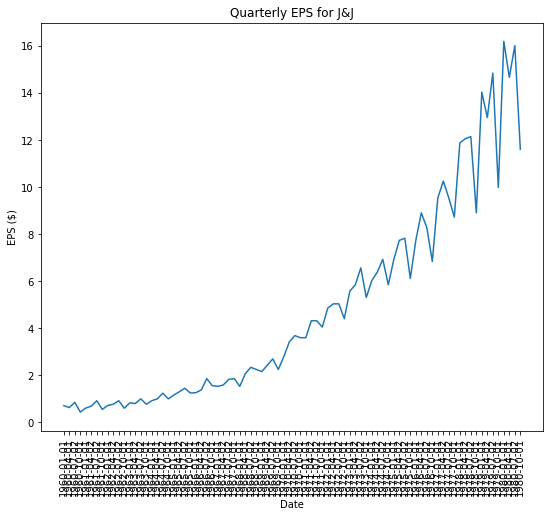

In [40]:
plt.plot(data['date'], data['data'])
plt.title("Quarterly EPS for J&J")
plt.ylabel("EPS ($)")
plt.xlabel("Date")
plt.xticks(rotation = 90)
plt.show()

In [41]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()
data.head()

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684


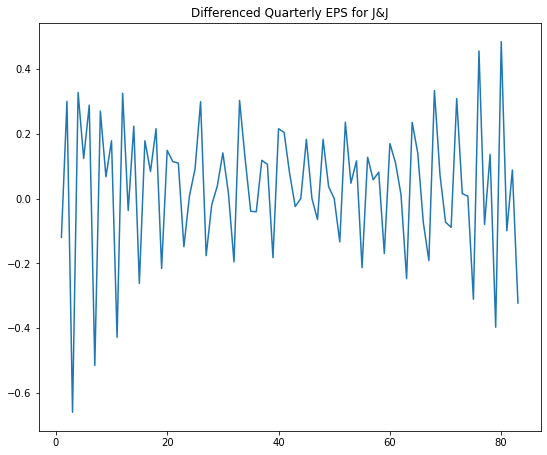

In [42]:
plt.plot(data['data_tr_1'][1:])
plt.title("Differenced Quarterly EPS for J&J")
plt.show()

In [43]:
data['data_tr_2'] = data['data_tr_1'][1:].diff(4) #karena quarterly
data.head(8)

,date,data,data_tr_1,data_tr_2
0,1960-01-01,0.71,NaN,NaN
1,1960-04-01,0.63,-0.119545,NaN
2,1960-07-02,0.85,0.299517,NaN
3,1960-10-01,0.44,-0.658462,NaN
4,1961-01-01,0.61,0.326684,NaN
5,1961-04-02,0.69,0.123233,0.242778
6,1961-07-02,0.92,0.287682,-0.011834
7,1961-10-01,0.55,-0.514455,0.144006


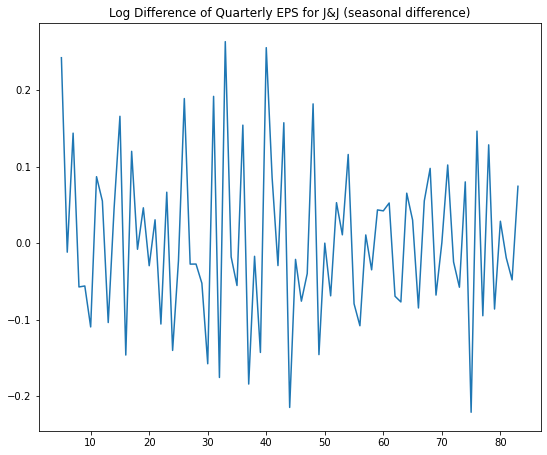

In [44]:
plt.plot(data['data_tr_2'])
plt.title("Log Difference of Quarterly EPS for J&J (seasonal difference)")
plt.show()

In [45]:
ad_fuller_result = adfuller(data['data_tr_2'][5:])

print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistic: -6.630805109914278
p-value: 5.721578695135751e-09


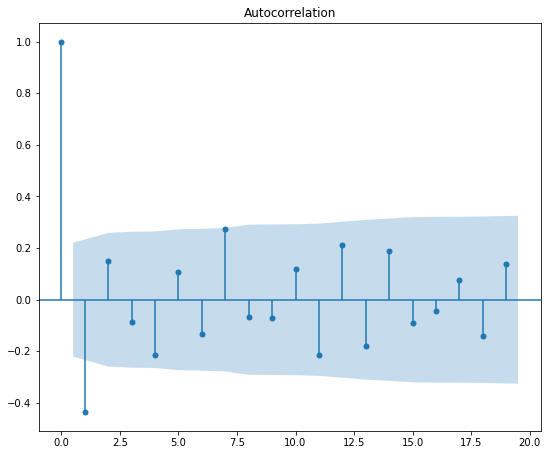

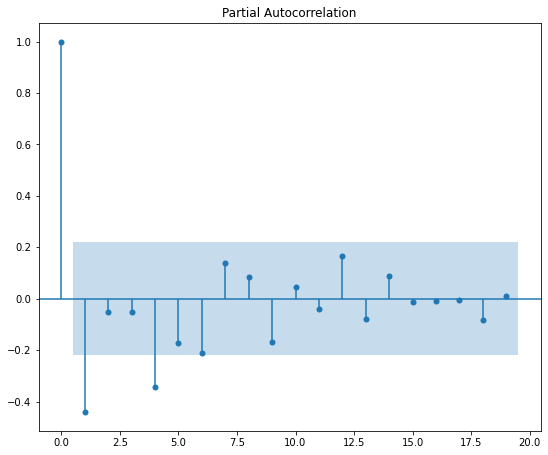

In [46]:
plot_acf(data['data_tr_2'][5:]);
plot_pacf(data['data_tr_2'][5:]);

In [47]:
def optimize_SARIMA(endog, parameters_list, d, D, s):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        endog - the observed variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(endog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [48]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

print(len(parameters_list))
print(parameters_list[:5])

256
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 1, 0)]


In [49]:
result_df = optimize_SARIMA(data['data'], parameters_list, 1, 1, 4)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(2, 3, 0, 0)",92.586853
1,"(2, 3, 1, 0)",93.976477
2,"(2, 3, 0, 1)",94.132374
3,"(3, 3, 0, 0)",94.469738
4,"(3, 2, 0, 3)",94.586142
...,...,...
251,"(0, 0, 3, 1)",144.211575
252,"(0, 0, 3, 3)",145.086431
253,"(0, 0, 2, 3)",145.465211
254,"(0, 0, 3, 2)",145.563923


In [50]:
best_model = SARIMAX(data['data'], order = (2,1,3) , seasonal_order = (0,1,0,4), simple_differencing = False)
res = best_model.fit(disp = False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   84
Model:             SARIMAX(2, 1, 3)x(0, 1, [], 4)   Log Likelihood                 -40.293
Date:                            Sat, 30 Apr 2022   AIC                             92.587
Time:                                    22:50:01   BIC                            106.804
Sample:                                         0   HQIC                            98.282
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4850      0.116    -12.834      0.000      -1.712      -1.258
ar.L2         -0.7909      0.131   

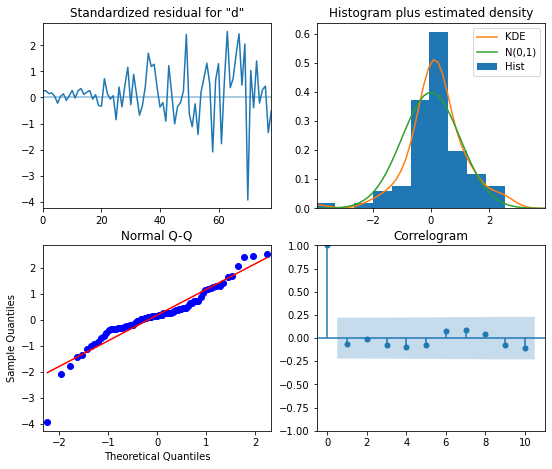

In [51]:
res.plot_diagnostics();

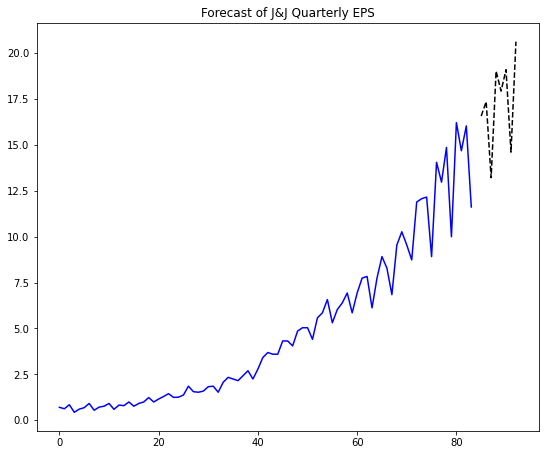

In [52]:
n_forecast = 8
predict = res.get_prediction(end = best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title = 'Forecast of J&J Quarterly EPS')
plt.show()

In [53]:
data['model'] = predict.predicted_mean
data.head(7)

,date,data,data_tr_1,data_tr_2,model
0,1960-01-01,0.71,NaN,NaN,0.000000
1,1960-04-01,0.63,-0.119545,NaN,0.710000
2,1960-07-02,0.85,0.299517,NaN,0.630000
3,1960-10-01,0.44,-0.658462,NaN,0.850000
4,1961-01-01,0.61,0.326684,NaN,0.795000
5,1961-04-02,0.69,0.123233,0.242778,0.530000
6,1961-07-02,0.92,0.287682,-0.011834,0.804984


In [54]:
mse = mean_squared_error(data['data'], data['model'])
print(f"MSE : {mse}")

MSE : 0.15613147195920524


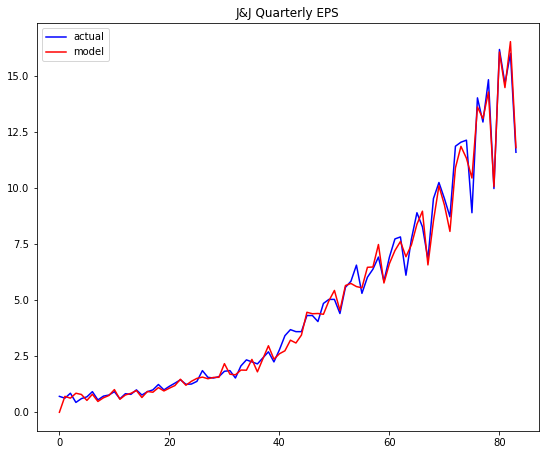

In [55]:
plt.plot(data['data'], color = 'blue', label = 'actual')
plt.plot(data['model'], color = 'red', label = 'model')
plt.legend(loc = 'best')
plt.title('J&J Quarterly EPS')
plt.show()

## dataframe forecasting 

In [56]:
result_dataframe = pd.DataFrame(list(zip(pd.date_range(start='1/1/1960', periods=92, freq='3M'), predict.predicted_mean)), columns = ['indeks', 'prediksi'])

In [57]:
result_dataframe

,indeks,prediksi
0,1960-01-31,0.000000
1,1960-04-30,0.710000
2,1960-07-31,0.630000
3,1960-10-31,0.850000
4,1961-01-31,0.795000
...,...,...
87,1981-10-31,13.202866
88,1982-01-31,19.002069
89,1982-04-30,17.914957
90,1982-07-31,19.079302
